In [1]:
%load_ext autoreload
%autoreload 2

%load_ext line_profiler

In [2]:
import pandas as pd
import numpy as np

import  matplotlib.pyplot as plt
import pickle

from chemistry import Molecule
from util import score
from pprint import pprint


In [3]:
with open('../data/molecules.pickle', 'rb') as f:
    molecules = pickle.load(f)

In [4]:
structures = pd.read_feather('../data/structures.feather')
labelled = pd.read_feather('../data/train.feather')
unlabelled = pd.read_feather('../data/test.feather')

In [41]:
from models import SKModel, partition_data

#data_df = labelled[labelled.type == '1JHC'].head(10)
data_df = labelled.head(10000)
train_df, test_df = partition_data(data_df, train_frac=1)
        
model = SKModel(molecules=molecules,
                structures=structures)
model.corr(train_df, train_df)

,id,atom_index_0,atom_index_1,scalar_coupling_constant,coupling_distance,coupling_2JHN,coupling_2JHH,coupling_3JHN,coupling_2JHC,coupling_1JHN,...,atom3_weight,bond01_dist,bond01_valency,bond01_strength,bond12_dist,bond12_valency,bond12_strength,bond23_dist,bond23_valency,bond23_strength
id,1.000000,0.259981,0.073881,-0.018507,0.012292,-0.001727,-0.029130,-0.028505,0.006195,-0.019294,...,0.040247,0.020076,NaN,0.029930,0.030477,0.017950,0.017152,0.034577,0.038806,0.035901
atom_index_0,0.259981,1.000000,0.085902,0.018727,-0.015419,-0.008281,-0.099798,-0.038061,0.065948,-0.028646,...,0.085976,0.054519,NaN,0.029774,0.021074,-0.002207,-0.012592,0.035244,-0.007247,-0.014255
atom_index_1,0.073881,0.085902,1.000000,-0.276717,-0.002612,-0.080930,0.487085,-0.060643,-0.316853,-0.066446,...,-0.243337,0.087032,NaN,-0.016251,0.186714,0.226451,0.313416,0.090138,0.159534,0.248786
scalar_coupling_constant,-0.018507,0.018727,-0.276717,1.000000,-0.009478,-0.059982,-0.274372,-0.075659,-0.275292,0.088647,...,-0.250893,0.047404,NaN,-0.042515,-0.898263,-0.839187,-0.891980,-0.313426,-0.291962,-0.301331
coupling_distance,0.012292,-0.015419,-0.002612,-0.009478,1.000000,-0.003968,0.003664,0.010174,-0.002824,0.001471,...,0.010257,-0.011245,NaN,0.005404,0.011610,0.006517,0.007525,0.010244,0.010497,0.009815
coupling_2JHN,-0.001727,-0.008281,-0.080930,-0.059982,-0.003968,1.000000,-0.057213,-0.026482,-0.087987,-0.017209,...,-0.104969,0.019204,NaN,0.000313,0.068484,0.063865,0.013263,-0.134570,-0.126037,-0.130781
coupling_2JHH,-0.029130,-0.099798,0.487085,-0.274372,0.003664,-0.057213,1.000000,-0.061093,-0.202984,-0.039700,...,-0.242161,0.085651,NaN,-0.031261,-0.042531,0.137285,0.291957,-0.310449,-0.290765,-0.301710
coupling_3JHN,-0.028505,-0.038061,-0.060643,-0.075659,0.010174,-0.026482,-0.061093,1.000000,-0.093953,-0.018376,...,0.321386,-0.020265,NaN,-0.033376,0.088413,0.064909,0.054256,0.190929,0.167618,0.115071
coupling_2JHC,0.006195,0.065948,-0.316853,-0.275292,-0.002824,-0.087987,-0.202984,-0.093953,1.000000,-0.061053,...,-0.372413,-0.050546,NaN,0.008755,0.324319,0.263532,0.240565,-0.477431,-0.447160,-0.463991
coupling_1JHN,-0.019294,-0.028646,-0.066446,0.088647,0.001471,-0.017209,-0.039700,-0.018376,-0.061053,1.000000,...,-0.072837,-0.279928,NaN,-0.271642,-0.218995,-0.202538,-0.210346,-0.093377,-0.087456,-0.090748


In [42]:
model.numeric_input_df

,coupling_distance,coupling_2JHN,coupling_2JHH,coupling_3JHN,coupling_2JHC,coupling_1JHN,coupling_3JHH,coupling_1JHC,coupling_3JHC,atom0_O,...,atom3_weight,bond01_dist,bond01_valency,bond01_strength,bond12_dist,bond12_valency,bond12_strength,bond23_dist,bond23_valency,bond23_strength
4045,1.094361,0,0,0,0,0,0,1,0,0,...,0,1.094361,1.0,411.0,0.000000,0.0,0.0,0.000000,0.0,0.0
4293,1.094361,0,0,0,1,0,0,0,0,0,...,0,1.095565,1.0,411.0,1.455800,1.0,346.0,0.000000,0.0,0.0
2166,1.094361,0,0,0,1,0,0,0,0,0,...,0,1.104177,1.0,411.0,1.457042,1.0,346.0,0.000000,0.0,0.0
3408,1.094361,0,0,1,0,0,0,0,0,0,...,14,1.097361,1.0,411.0,1.507940,1.0,346.0,1.261478,1.0,305.0
3522,1.094361,0,0,0,0,0,0,0,1,0,...,12,1.078653,1.0,411.0,1.354492,1.0,358.0,1.373534,1.0,358.0
2289,2.246313,0,0,0,1,0,0,0,0,0,...,0,1.094064,1.0,411.0,1.520532,1.0,346.0,0.000000,0.0,0.0
6722,2.114161,0,0,0,0,0,0,0,1,0,...,12,0.963878,1.0,459.0,1.426659,1.0,358.0,1.466062,1.0,346.0
237,2.114161,0,0,0,0,0,0,1,0,0,...,0,1.095225,1.0,411.0,0.000000,0.0,0.0,0.000000,0.0,0.0
7894,2.114161,0,0,0,0,0,0,0,1,0,...,12,1.095252,1.0,411.0,1.513710,1.0,346.0,1.510890,1.0,346.0
8097,2.102853,0,0,0,0,0,0,0,1,0,...,12,1.095320,1.0,411.0,1.526584,1.0,346.0,1.559815,1.0,346.0


1JHC score: 1.764978047789276 (trained on 5835 elements)
1JHN score: 1.2046705205678145 (trained on 468 elements)
2JHC score: 0.6335055529426645 (trained on 8262 elements)
2JHH score: 0.742933992485981 (trained on 3786 elements)
2JHN score: 0.26739465459718226 (trained on 912 elements)
3JHC score: 0.7926681043750052 (trained on 10052 elements)
3JHH score: 1.100784597074481 (trained on 4414 elements)
3JHN score: -0.20090376843199134 (trained on 1266 elements)


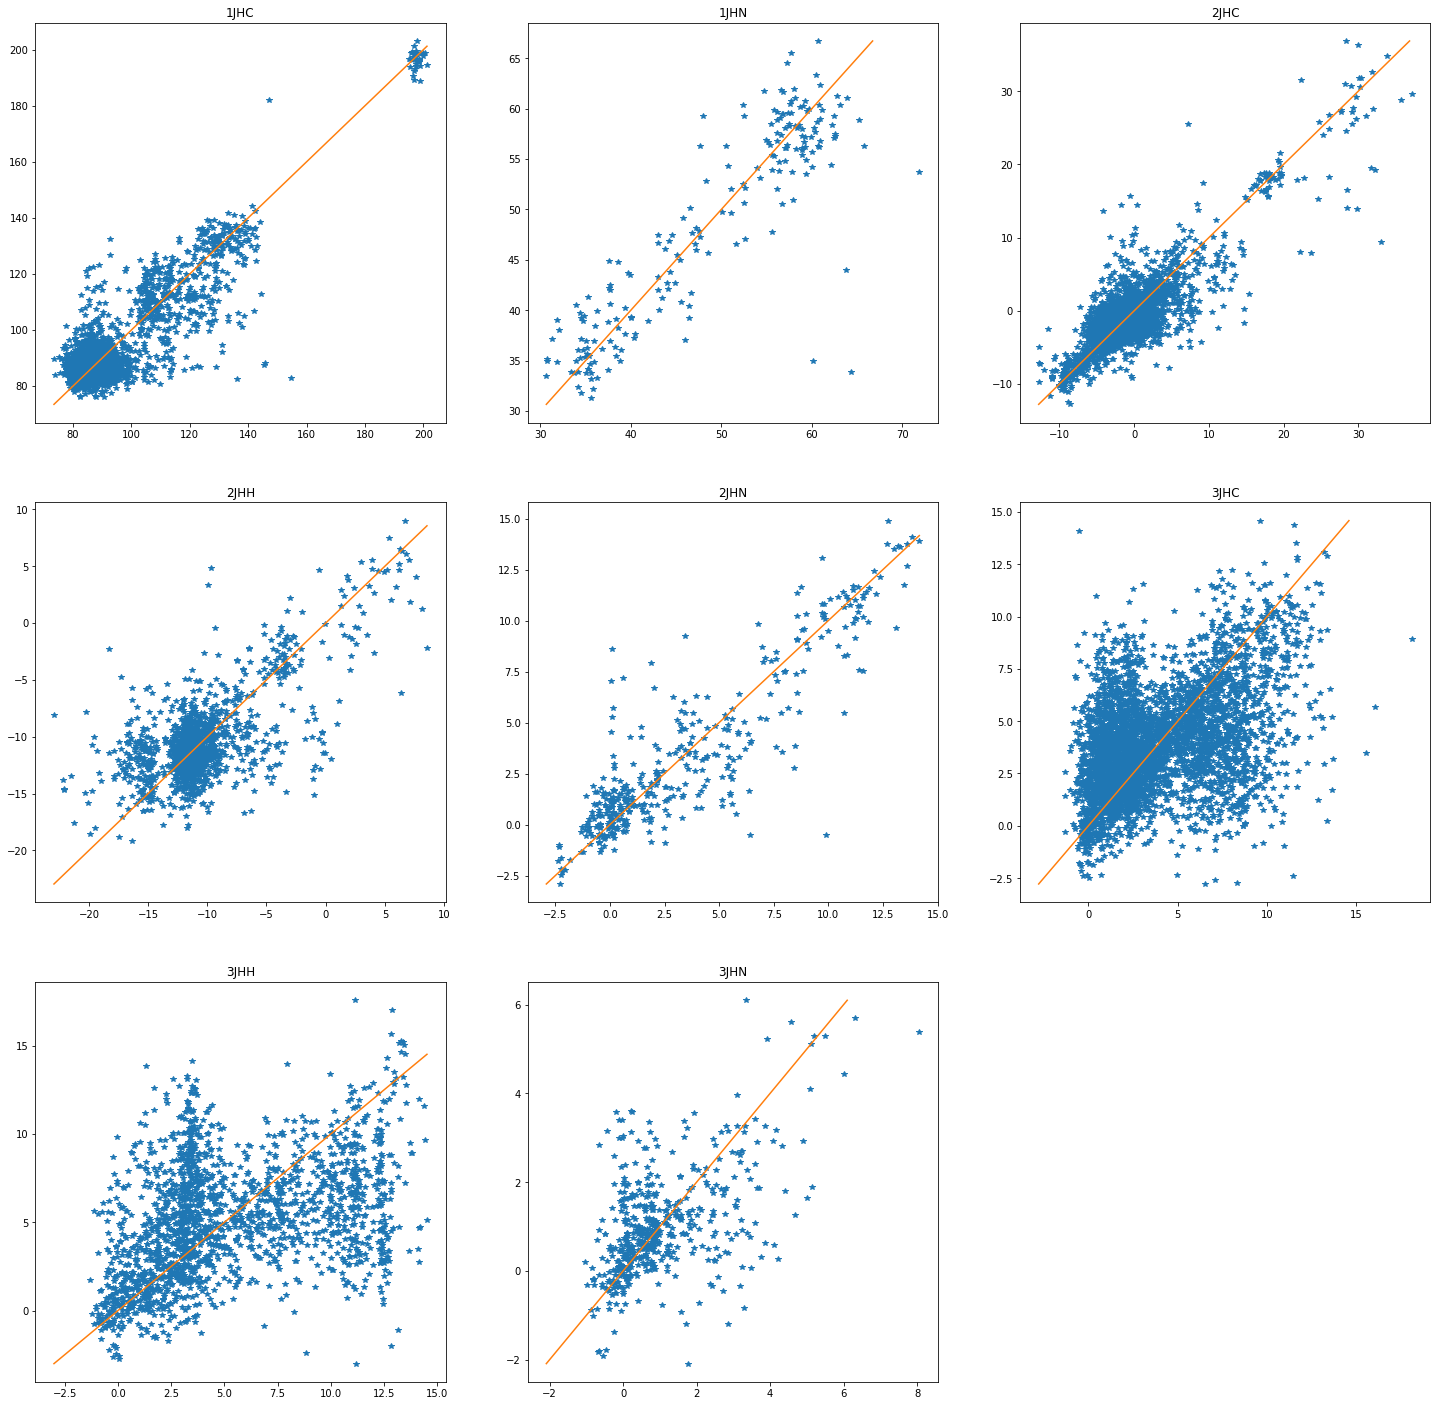

In [53]:
from models import XGBModel, LGBModel
from models import partition_data

def test(data):
    plt.figure(figsize=(25, 25))
    for i, t in enumerate(sorted(data.type.unique()), 1):
        data_df = data[data.type == t]
        train_df, test_df = partition_data(data_df)
        
        model = LGBModel(dict(molecules=molecules, 
                              structures=structures),
                         dict(n_jobs=8,
                              max_depth=9,
                              boosting_type='gbdt',
                              num_leaves=128,
                              min_child_samples=20,
                              learning_rate=0.2,
                              n_estimators=1000,
                              reg_alpha=0.1,
                              reg_lambda=0.3,
                              subsample_freq = 1,
                              subsample = 0.9,
#                               verbose=500
                             ))
  
        model.fit(train_df, train_df)
        output, score = model.evaluate(test_df, test_df)
        print(f'{t} score: {score} (trained on {len(train_df)} elements)')
        plt.subplot(3, 3, i)
        plt.plot(test_df.scalar_coupling_constant, output, '*')
        mn = min(test_df.scalar_coupling_constant.min(), output.min())
        mx = min(test_df.scalar_coupling_constant.max(), output.max())
        plt.plot([mn, mx], [mn, mx])
        plt.title(t)
    plt.show()
        
test(labelled.head(50000))


In [59]:
models = {}
data = labelled.sample(1000)
for t in sorted(data.type.unique()):
    train_df = data[data.type == t]
    model = LGBModel(dict(molecules=molecules, 
                          structures=structures),
                     dict(n_jobs=8,
                          max_depth=9,
                          boosting_type='gbdt',
                          num_leaves=128,
                          min_child_samples=20,
                          learning_rate=0.2,
                          n_estimators=1000,
                          reg_alpha=0.1,
                          reg_lambda=0.3,
                          subsample_freq = 1,
                          subsample = 0.9))
    models[t] = model
    model.fit(train_df, train_df)

In [67]:
def f(data):
    for t in sorted(data.type.unique()):
        predict_df = data[data.type == t]
        output = models[t].predict(predict_df)
        #print(len(predict_df), output.shape)
    
%prun f(unlabelled.sample(100))


         1053059 function calls (1040783 primitive calls) in 13.212 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       64    3.295    0.051    3.296    0.052 {method 'factorize' of 'pandas._libs.hashtable.Int64Factorizer' objects}
      128    1.448    0.011    1.448    0.011 dtypes.py:416(<listcomp>)
       32    1.416    0.044    1.416    0.044 {method 'factorize' of 'pandas._libs.hashtable.Factorizer' objects}
      128    1.255    0.010    1.255    0.010 {pandas._libs.hashing.hash_object_array}
      178    0.703    0.004    0.980    0.006 {pandas._libs.algos.ensure_object}
       16    0.672    0.042    0.684    0.043 {pandas._libs.join.inner_join}
   183780    0.337    0.000    0.646    0.000 {built-in method builtins.isinstance}
    83908    0.198    0.000    0.292    0.000 generic.py:7(_check)
       40    0.194    0.005    0.194    0.005 {pandas._libs.algos.take_2d_axis0_float32_float32}
      185    0.178    0